In [2]:
import detection as eddy
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from tqdm import tqdm
import ast

import EddyDetectionV2 as eddy

# Set default font size to match LaTeX document
plt.rcParams.update({
    'font.size': 11,       # Default text size
    'axes.titlesize': 10,  # Title size
    'axes.labelsize': 10,  # Axis label size
    'xtick.labelsize': 8, # X-tick label size
    'ytick.labelsize': 8, # Y-tick label size
    'legend.fontsize': 8, # Legend font size
    'figure.titlesize': 12 # Figure title size
})

In [14]:
time = ['2018-03-20T00:00:00.000000000','2018-06-30T00:00:00.000000000']
####################################################################


# Import data #######################################################################################################################
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(70,75)).sel(X=slice(-22,2))
depth_no_nan = depth
depth = depth.where(depth > 0, np.nan)

df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Background_var_eddies.nc')
display(df)
df_OW = df['Okubo_Weiss']
df_OW = df_OW*(1/(10**(-9)))
df_eta = df['Eta']

od = ospy.OceanDataset(df)
od = od.compute.horizontal_velocity_magnitude()
od = od.compute.eddy_kinetic_energy()
#od = od.compute.curl()

df_EKE = od['EKE']
df_hor_vel = od['hor_vel']
# Delete no longer used variables which uses memory
del od, df
#####################################################################################################################################
# Child domain
domain_center = [[-20,0],[71,74]]
OW_center = df_OW.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1])).sel(Z=-1)
eta_center = df_eta.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Parent domain
eta = df_eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1))
OW = df_OW.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1)).sel(Z=-1)


# Resample data
eta = eta.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
OW = OW.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')
hor_vel = df_hor_vel.resample(time='D').mean(dim='time')

# Define time extent
eta = eta.sel(time=slice(time[0],time[1]))
eta_center = eta_center.sel(time=slice(time[0],time[1]))
OW = OW.sel(time=slice(time[0],time[1]))
OW_center = OW_center.sel(time=slice(time[0],time[1]))
hor_vel = hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))
EKE = df_EKE.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

eta = eta.where(depth > 0, np.nan)
OW = OW.where(depth > 0, np.nan)

<xarray.Dataset>
Dimensions:      (Z: 1, Zp1: 2, Zu: 1, Zl: 1, X: 765, Y: 628, Xp1: 766,
                  Yp1: 629, time: 365, time_midp: 364)
Coordinates: (12/18)
  * Z            (Z) float64 -1.0
  * Zp1          (Zp1) float64 0.0 -2.0
  * Zu           (Zu) float64 -2.0
  * Zl           (Zl) float64 0.0
  * X            (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
  * Y            (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    ...           ...
  * time         (time) datetime64[ns] 2017-09-01 2017-09-02 ... 2018-08-31
    YU           (Y, Xp1) float64 ...
    XU           (Y, Xp1) float64 ...
    YV           (Yp1, X) float64 ...
    XV           (Yp1, X) float64 ...
  * time_midp    (time_midp) datetime64[ns] 2017-09-01T12:00:00 ... 2018-08-3...
Data variables:
    U            (time, Z, Y, Xp1) float64 ...
    V            (time, Z, Yp1, X) float64 ...
    Eta          (time, Y, X) float64 ...
    Okubo_Weiss  (time, Z, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

Computing magnitude of horizontal velocity
Computing weighted_mean.
Computing weighted_mean.
Computing kinetic energy using the following parameters: {'eps_nh': 0}.


In [5]:
FWC = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWC_full_domain.nc')['__xarray_dataarray_variable__'].sel(Y=slice(70,75)).sel(X=slice(-22,2)).sel(time=slice(time[0],time[1]))
FWC = FWC.resample(time='D').mean(dim='time')

In [6]:
# Eddy centre points
with open("eddyCenterpoints_fullYear.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

# Dates to find
dates_to_find = time

# Convert dates to numpy datetime64
dates_to_find = np.array(dates_to_find, dtype='datetime64[ns]')

# Find the index positions
indices = [df_eta.time.where(df_eta.time == date, drop=True).time.values[0] for date in dates_to_find]

# Convert the datetime64 values to integer indices
index_positions = [np.where(df_eta.time.values == date)[0][0] for date in dates_to_find]

print(index_positions)

eddyLocation = eddyLocation[index_positions[0]:index_positions[1]+1]

[200, 302]


In [7]:
eddies = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Eddies_fullYear.nc')
eddies = eddies['EddyDetection'].sel(time=slice(time[0],time[1]))

In [8]:
eddies = eddies.where(eddies != 4, other=np.nan)

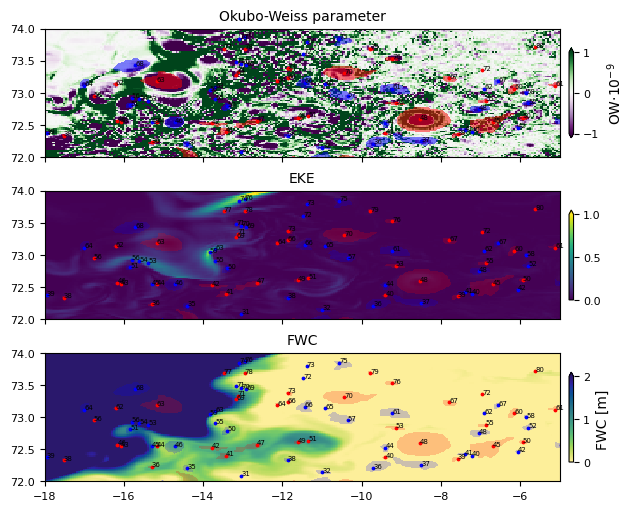

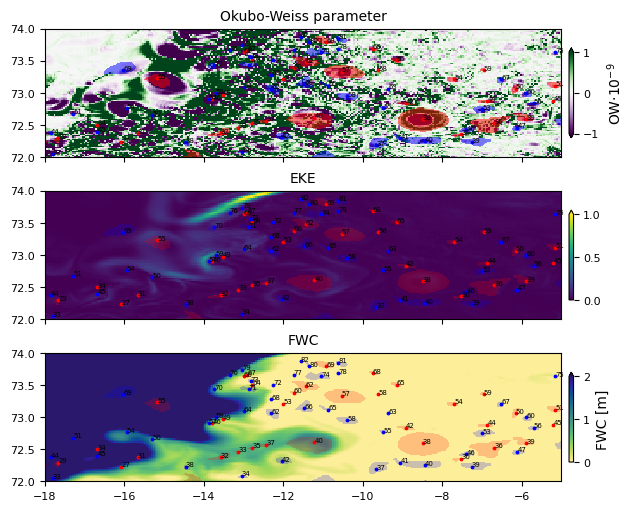

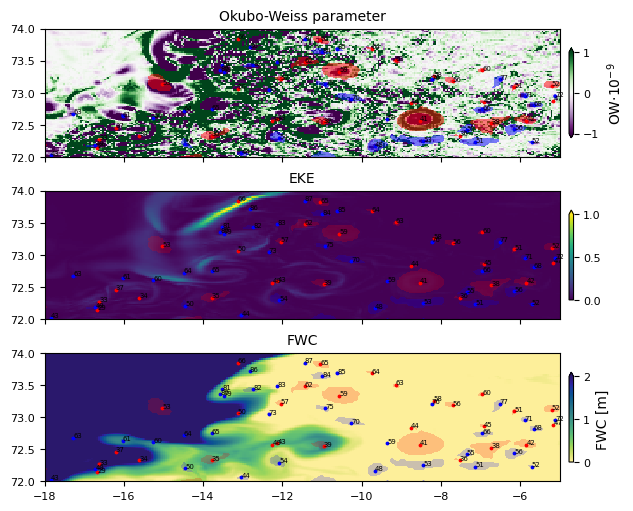

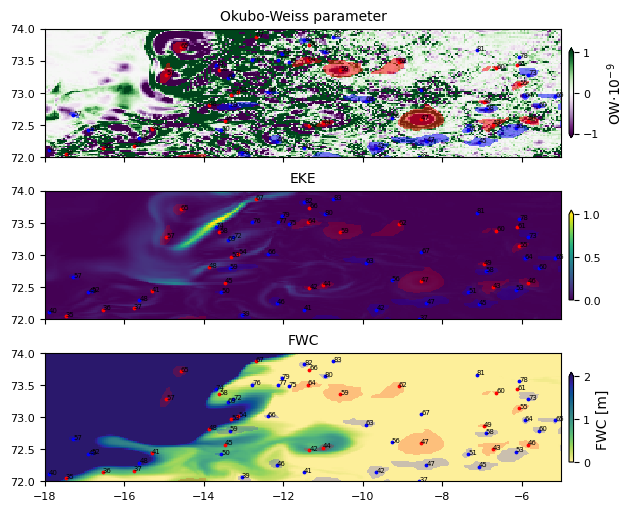

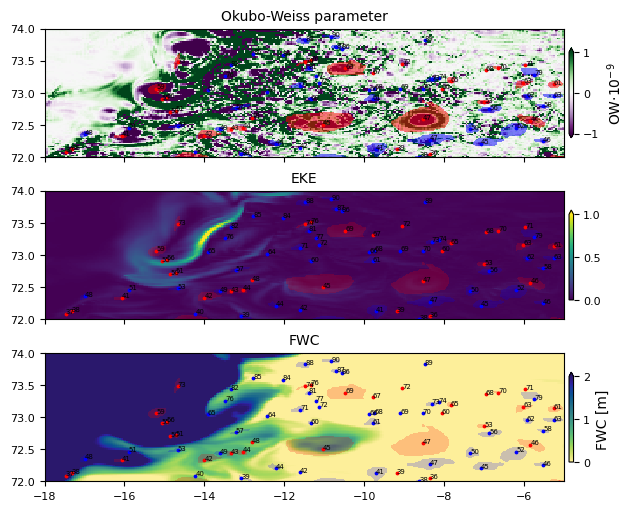

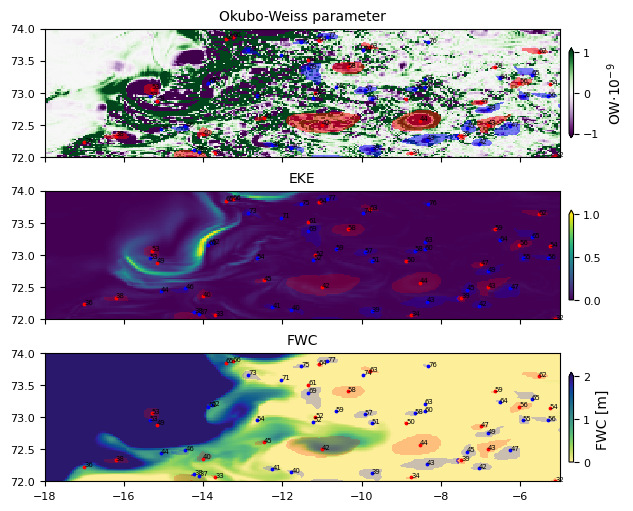

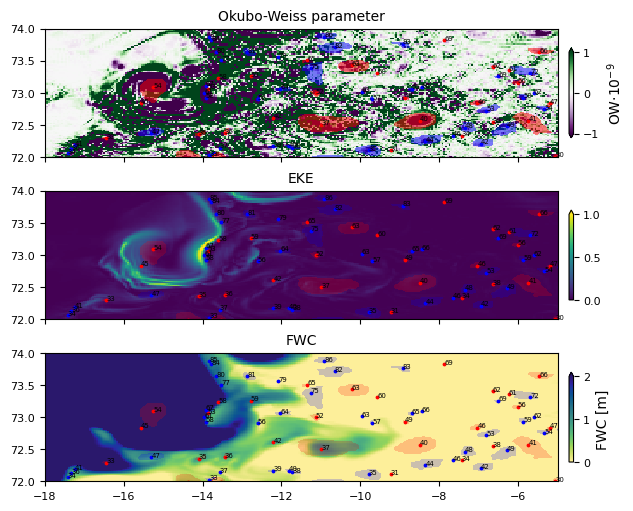

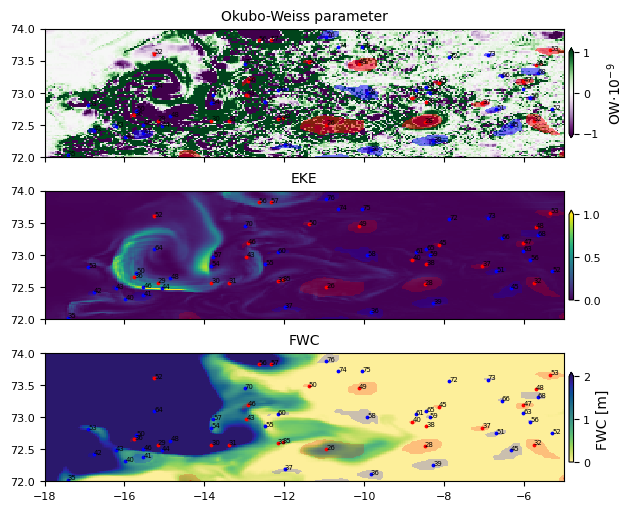

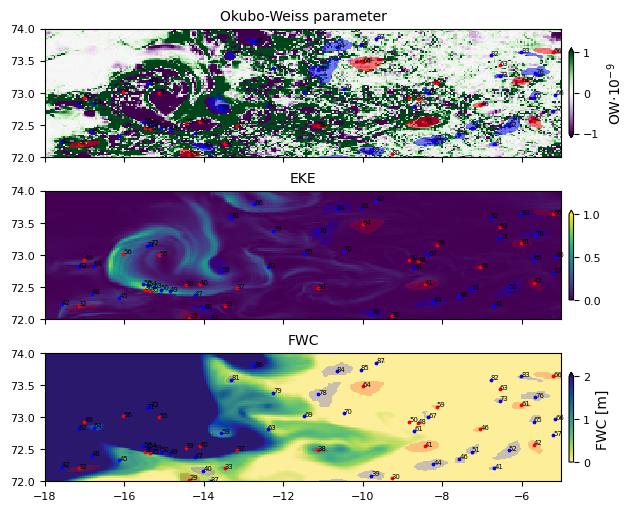

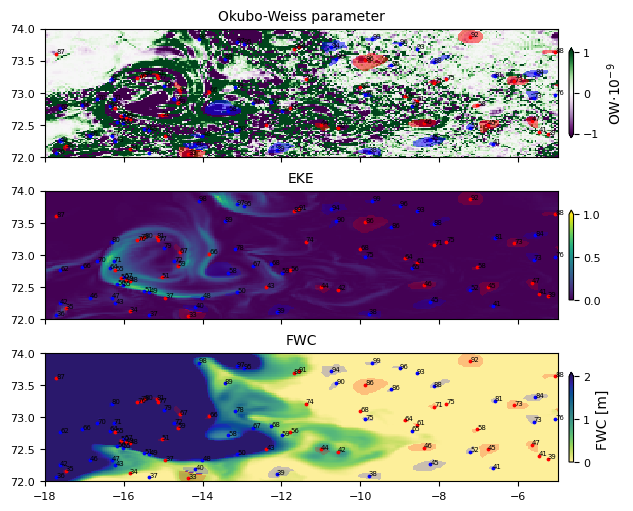

In [9]:
time_ = np.arange(0,10)
for time in time_:
    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6.2217,5),sharex=True,sharey=True,layout='constrained')

    # Define the custom colormap
    colors = ['red', 'blue', 'yellow', 'green']
    cmap = mcolors.ListedColormap(colors)

    # Define the normalization
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    mesh = ax1.pcolormesh(OW.X,OW.Y,OW[time],vmin=-1,vmax=1,cmap='PRGn')
    cbar = fig.colorbar(mesh,extend='both',shrink=0.7,pad=0.01)
    cbar.set_label(r'OW$\cdot$10$^{-9}$')
    ax1.contourf(eddies.X,eddies.Y,eddies[time],cmap=cmap,norm=norm,alpha=0.5)

    for i, data in enumerate(eddyLocation[time][0]):
        ax1.scatter(data[1],data[0],c='r',s=3)
        ax1.annotate(i,xy=[data[1],data[0]],fontsize=5)
    for i, data in enumerate(eddyLocation[time][1]):
        ax1.scatter(data[1],data[0],c='b',s=3)
        ax1.annotate(i,xy=[data[1],data[0]],fontsize=5)

    ax1.set_xlim(-18,-5)
    ax1.set_ylim(72,74)
    ax1.set_title('Okubo-Weiss parameter')

    mesh = ax2.pcolormesh(EKE.X,EKE.Y,EKE[time],vmin=0,vmax=1)
    cbar = fig.colorbar(mesh,shrink=0.7,pad=0.01, extend='max')
    ax2.contourf(eddies.X,eddies.Y,eddies[time],cmap=cmap,norm=norm,alpha=0.2)
    for i, data in enumerate(eddyLocation[time][0]):
        ax2.scatter(data[1],data[0],c='r',s=3)
        ax2.annotate(i,xy=[data[1],data[0]],fontsize=5)
    for i, data in enumerate(eddyLocation[time][1]):
        ax2.scatter(data[1],data[0],c='b',s=3)
        ax2.annotate(i,xy=[data[1],data[0]],fontsize=5)

    ax2.set_title('EKE')

    mesh = ax3.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap=cmo.haline_r,vmin=0,vmax=2)
    cbar = fig.colorbar(mesh, pad=0.01, shrink=0.7,extend='max')
    cbar.set_label('FWC [m]')
    ax3.contourf(eddies.X,eddies.Y,eddies[time],cmap=cmap,norm=norm,alpha=0.2)
    for i, data in enumerate(eddyLocation[time][0]):
        ax3.scatter(data[1],data[0],c='r',s=3)
        ax3.annotate(i,xy=[data[1],data[0]],fontsize=5)
    for i, data in enumerate(eddyLocation[time][1]):
        ax3.scatter(data[1],data[0],c='b',s=3)
        ax3.annotate(i,xy=[data[1],data[0]],fontsize=5)

    ax3.set_title('FWC')


    fig.savefig(f'/nird/home/ekv036/MSc/Fig/EddyTest/EddyTest2/eddyParameters{time}',dpi=300, facecolor='w', edgecolor='w',
            orientation='landscape', format=None,
            transparent=False, bbox_inches=None,pad_inches=0.25)

In [10]:
EKE_std = EKE.std()
display(EKE_std.values*3)

0.10932510785997265

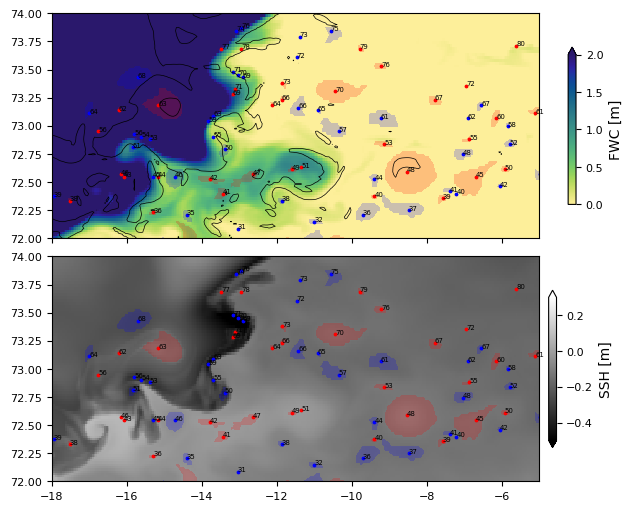

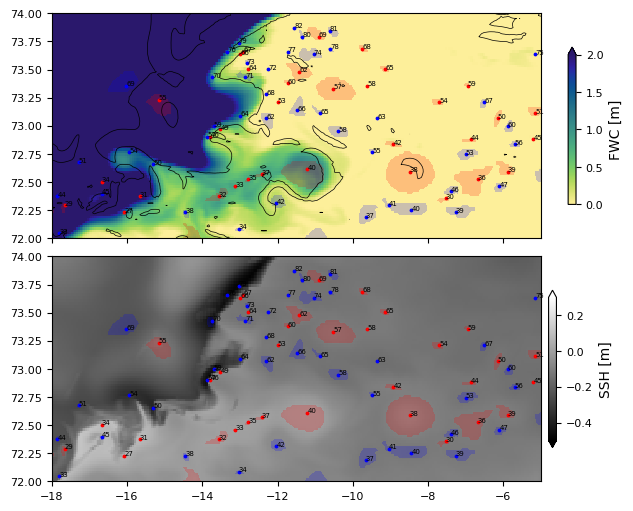

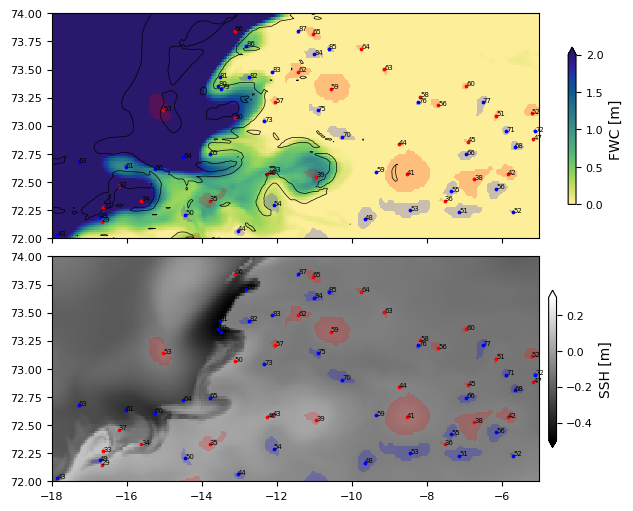

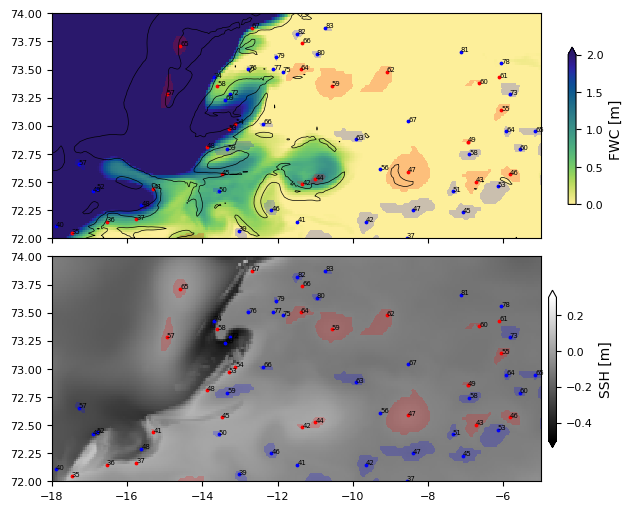

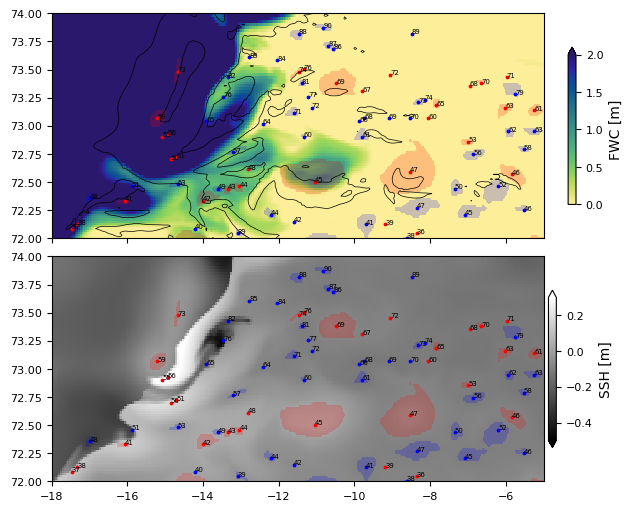

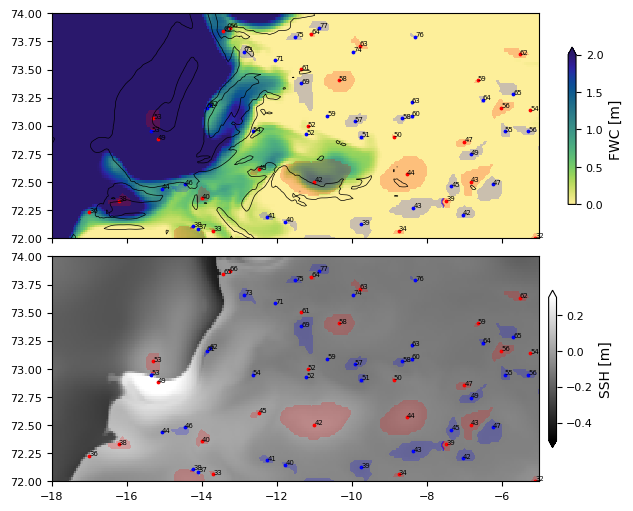

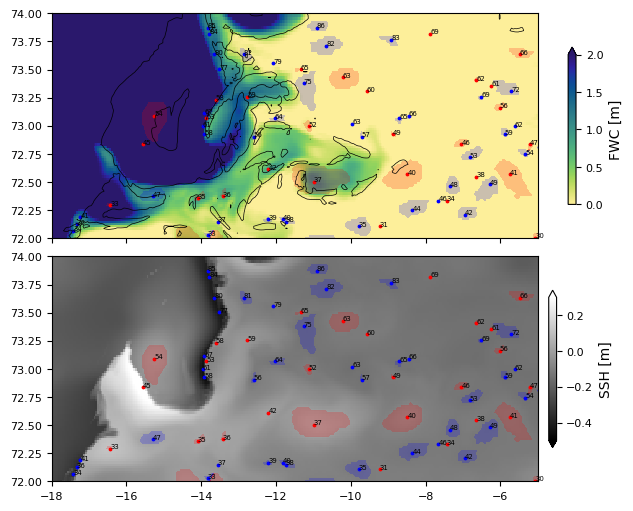

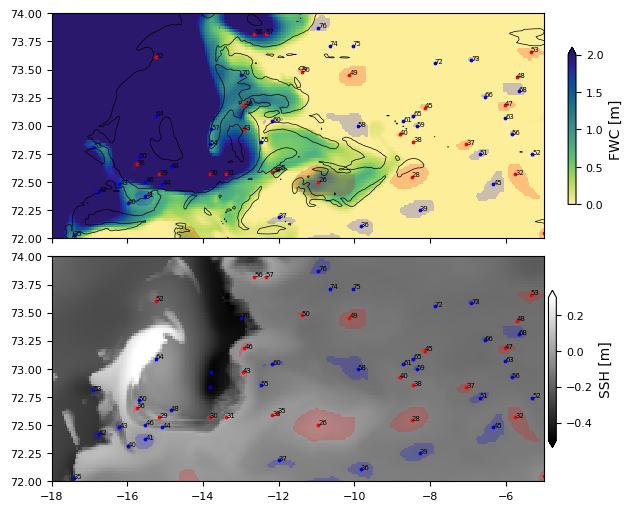

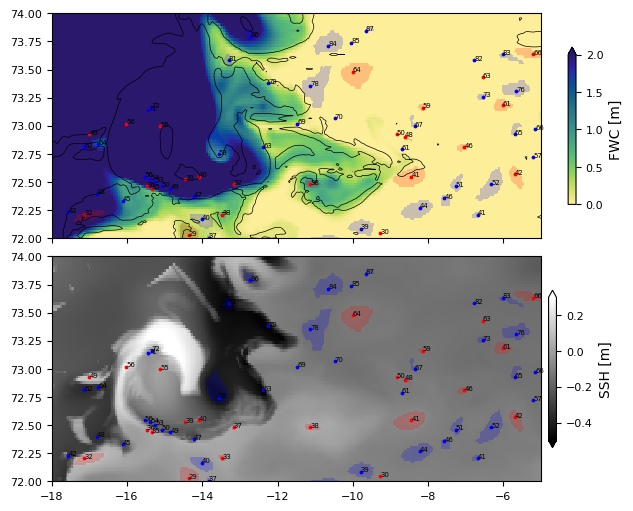

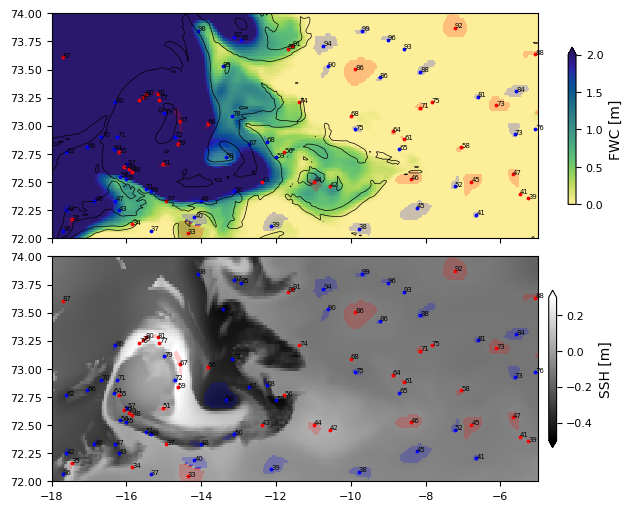

In [11]:
time_ = np.arange(0,10)
for time in time_:
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6.2217,5),sharex=True,sharey=True,layout='constrained')
    mesh = ax1.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap=cmo.haline_r,vmin=0,vmax=2)
    cbar = fig.colorbar(mesh, pad=0.05, shrink=0.7,extend='max')
    cbar.set_label('FWC [m]')

    cntr = ax1.contour(EKE.X,EKE.Y,EKE[time],levels=[EKE_std.values],colors='black',linewidths=0.5)
    ax1.contourf(eddies.X,eddies.Y,eddies[time],cmap=cmap,norm=norm,alpha=0.2)
    for i, data in enumerate(eddyLocation[time][0]):
        ax1.scatter(data[1],data[0],c='r',s=3)
        ax1.annotate(i,xy=[data[1],data[0]],fontsize=5)
    for i, data in enumerate(eddyLocation[time][1]):
        ax1.scatter(data[1],data[0],c='b',s=3)
        ax1.annotate(i,xy=[data[1],data[0]],fontsize=5)

    ax1.set_xlim(-18,-5)
    ax1.set_ylim(72,74)

    mesh = ax2.pcolormesh(eta.X,eta.Y,eta[time],cmap='binary_r',vmin=-0.5,vmax=0.3)
    cbar = fig.colorbar(mesh,pad=0.01,shrink=0.7,extend='both')
    cbar.set_label('SSH [m]')
    ax2.contourf(eddies.X,eddies.Y,eddies[time],cmap=cmap,norm=norm,alpha=0.2)
    for i, data in enumerate(eddyLocation[time][0]):
        ax2.scatter(data[1],data[0],c='r',s=3)
        ax2.annotate(i,xy=[data[1],data[0]],fontsize=5)
    for i, data in enumerate(eddyLocation[time][1]):
        ax2.scatter(data[1],data[0],c='b',s=3)
        ax2.annotate(i,xy=[data[1],data[0]],fontsize=5)

    fig.savefig(f'/nird/home/ekv036/MSc/Fig/EddyTest/EddyTest3/eddyEKEOuterRegion{time}',dpi=300, facecolor='w', edgecolor='w',
            orientation='landscape', format=None,
            transparent=False, bbox_inches=None,pad_inches=0.25)

In [12]:
from PIL import Image
import os

# Define the folder containing the PNG files and the output GIF file
input_folder = '/nird/home/ekv036/MSc/Fig/EddyTest/EddyTest2'
output_gif = '/nird/home/ekv036/MSc/Fig/EddyTest/EddyTest2/eddyparameters.gif'

# Get a list of all PNG files in the folder
png_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

# Sort the files if necessary (e.g., if they need to be in a specific order)
png_files.sort()

# Open the images and store them in a list
images = [Image.open(os.path.join(input_folder, file)) for file in png_files]

# Save the images as a GIF
images[0].save(output_gif, save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)

print(f"GIF saved as {output_gif}")

GIF saved as /nird/home/ekv036/MSc/Fig/EddyTest/EddyTest2/eddyparameters.gif


In [13]:
# Define the folder containing the PNG files and the output GIF file
input_folder = '/nird/home/ekv036/MSc/Fig/EddyTest/EddyTest3'
output_gif = '/nird/home/ekv036/MSc/Fig/EddyTest/EddyTest3/eddyEKEouterregion.gif'

# Get a list of all PNG files in the folder
png_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

# Sort the files if necessary (e.g., if they need to be in a specific order)
png_files.sort()

# Open the images and store them in a list<
images = [Image.open(os.path.join(input_folder, file)) for file in png_files]

# Save the images as a GIF
images[0].save(output_gif, save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)

print(f"GIF saved as {output_gif}")

GIF saved as /nird/home/ekv036/MSc/Fig/EddyTest/EddyTest3/eddyEKEouterregion.gif
